In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings(action='ignore')

In [127]:
# Data Loading
df = pd.read_csv('./Data/kodex200_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      2462 non-null   object 
 1   NAV     2462 non-null   float64
 2   시가      2462 non-null   int64  
 3   고가      2462 non-null   int64  
 4   저가      2462 non-null   int64  
 5   종가      2462 non-null   int64  
 6   거래량     2462 non-null   int64  
 7   괴리율     2462 non-null   float64
 8   추적오차율   2462 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 173.2+ KB


### 데이터 전처리  

+ Input, Output variables Setting
+ Data Split
+ Data Scaling
+ Convert to Tensor

## Sequential Dataset 생성
![sq](./image/sq_set.png)

In [133]:
# 1) Train, Test 데이터 분리
stock_data = df.iloc[:, 1:]
train_size = 0.9
n_train = int(train_size*stock_data.shape[0]) #train size 따른 데이터 갯수
df_train = stock_data[0: n_train]
df_test = stock_data[n_train:]


# 2) 데이터 스케일링 
scaler = MinMaxScaler()
train_set_scaled = scaler.fit(df_train)
train_set_scaled = scaler.transform(df_train)
test_set = scaler.transform(df_test)


# 3) Sequence Length, 예측 기간(Step), Single Output 여부 등 정의
seq_len = 5  # 과거 5일의 데이터를 feature로 사용
pred_days= 1 # 향후 1일의 y를 예측
batch = 100 # 배치 사이즈

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_set_scaled[i - seq_len:i, 0:train_set_scaled.shape[1]])
    trainY.append(train_set_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_set)-pred_days +1):
    testX.append(test_set[i - seq_len:i, 0:test_set.shape[1]])
    testY.append(test_set[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print(f"trainX:{trainX.shape}, testX:{testX.shape}, trainY:{trainY.shape}, testY:{testY.shape}")

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

trainX:(2210, 5, 8), testX:(242, 5, 8), trainY:(2210, 1), testY:(242, 1)


 > Tensor Shape : (Time Step, Length, Features) 

# Many-to-one
<img src="./image/many_to_one.png" alt="many" style="width:150px; height:150px;">

# LSTM 모델

In [120]:
class LSTM(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x) :
        # Propagate input through LSTM
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
           
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

# 모델 학습 함수

In [134]:
def train_model(model, train_df, num_epochs = None, learn_rate = None, verbose = 1, patience = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learn_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # H(x) 계산
            outputs = model.forward(x_train)
            
            # cost 계산
            loss = criterion(outputs, y_train)                 
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss.item()/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break

    return model.eval(), train_hist

# 모델 하이퍼 파라미터 조절 및 학습

In [135]:
# Hyper Parameter
num_classes = 1 # number of output classes 

input_size = 8 # Feature size
hidden_size = 25 # Hidden size
num_layers = 1 

learning_rate = 0.0001
nb_epochs = 300 # Number of epochs

In [136]:
# 모델 학습 학습된 모델은 trained_model에 저장
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
trained_model, train_hist = train_model(model, dataloader, num_epochs = nb_epochs, learn_rate = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.2642
Epoch: 0020 train loss : 0.0027
Epoch: 0040 train loss : 0.0004
Epoch: 0060 train loss : 0.0003
Epoch: 0080 train loss : 0.0003
Epoch: 0100 train loss : 0.0003
Epoch: 0120 train loss : 0.0003
Epoch: 0140 train loss : 0.0003

 Early Stopping


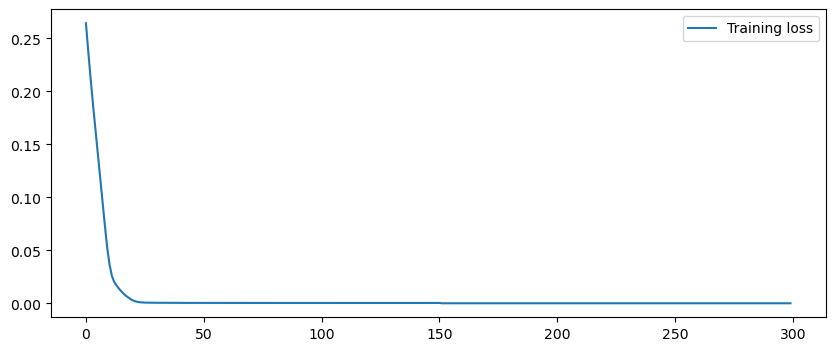

In [137]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

# 예측 시각화

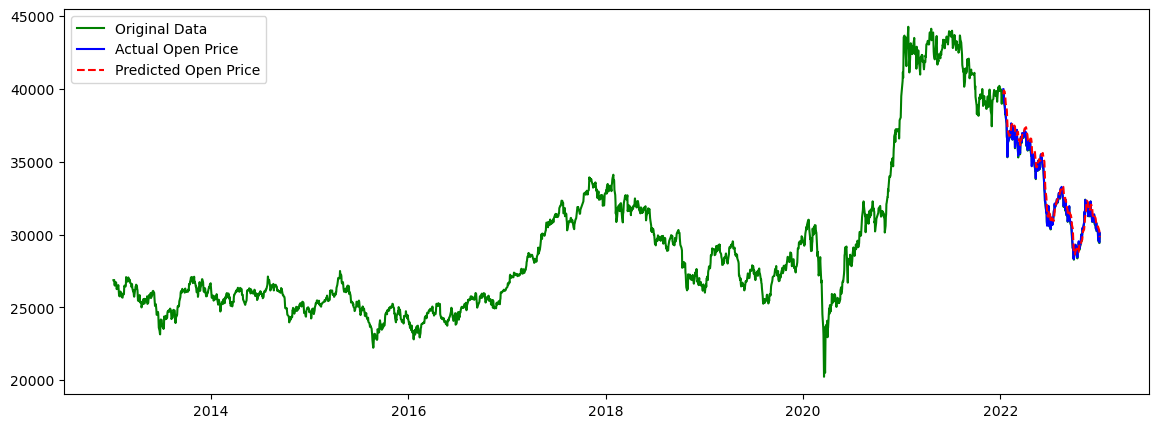

In [139]:
# Original Data 종가
original_close = df['종가'].values

# 일자 계산
dates = pd.to_datetime(df['날짜'])
train_dates = dates[0: n_train]
test_dates = dates[n_train:]

# 훈련된 모델을 통해 예측값 구하기 및 시각화를 위해 텐서 -> 넘파일 변환
train_predict = trained_model(testX_tensor)
prediction = train_predict.data.numpy()
label_y = testY_tensor.data.numpy()

# 스케일링 된 값 원래값으로 역변환
arr = np.zeros((prediction.shape[0], len(df_train.columns)))

arr[:, 0] = np.squeeze(prediction)
y_pred = scaler.inverse_transform(arr)[:, 0]

arr[:, 0] = np.squeeze(testY)
y_original = scaler.inverse_transform(arr)[:, 0]

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(dates, original_close, color='green', label = 'Original Data')
plt.plot(test_dates[seq_len:], y_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.legend()
plt.show()

# 확대 시각화

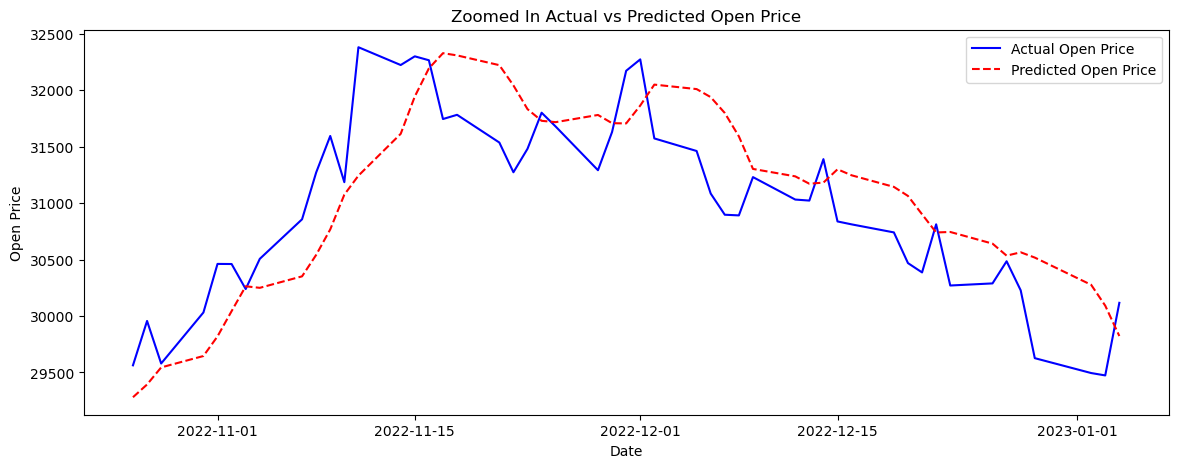

In [140]:
# 확대 시각화 날짜 설정
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# 확대 시각화 날짜 인덱스 적용하여 시각화
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         y_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price')
plt.legend()
plt.show()